In [52]:
import torch
import os
import sys
import copy

In [53]:
import matplotlib.pyplot as plt

In [54]:
import numpy as np
import networkx as nx

In [55]:
import wandb

In [56]:
epochs = 5

In [57]:
device = "cuda:0"

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [77]:
from src.cv import build_masks, crossvalidation

In [61]:
from src.graph_construction import graph
nycgraph, nyc_rebuild_info = graph(
    "new-york",
    neighbor_radius=70,
    building_buffer=30,
    test_percent=15
)

In [62]:
nyc_rebuild_info.keys()

dict_keys(['rebuild_idx', 'recorded', 'node_data', 'footprints', 'complete_footprints', 'training_mask', 'simple_ids'])

In [63]:
from src.graph_construction import graph
austingraph, austin_rebuild_info = graph(
    "austin",
    neighbor_radius=90,
    building_buffer=100,
    test_percent=15
)

In [64]:
austingraph

HeteroData(
  pano={ x=[1678, 6] },
  footprint={
    x=[90, 4],
    y=[90],
    train_mask=[90],
    test_mask=[90]
  },
  (footprint, contains, pano)={ edge_index=[2, 225] },
  (pano, links, pano)={ edge_index=[2, 4702] },
  (pano, rev_contains, footprint)={ edge_index=[2, 225] }
)

In [65]:
from src.graph_construction import graph
sfgraph, rebuild_info = graph(
    "san-fransisco",
    neighbor_radius=70,
    building_buffer=50,
    test_percent=15
)

In [66]:
sfgraph

HeteroData(
  pano={ x=[39, 6] },
  footprint={
    x=[1530, 13],
    y=[1530],
    train_mask=[1530],
    test_mask=[1530]
  },
  (footprint, contains, pano)={ edge_index=[2, 16] },
  (pano, links, pano)={ edge_index=[2, 39] },
  (pano, rev_contains, footprint)={ edge_index=[2, 16] }
)

In [67]:
import networkx as nx

In [68]:
nyc_mask = nyc_rebuild_info['training_mask'].cpu().numpy()
nyc_cvs = build_masks(
    nyc_mask, 
    n_cv = 5
)

In [69]:
from src.model import NullModel

input_shape = nycgraph['footprint'].x.shape[1]
nullmodel = NullModel(layers=2, input_channels = input_shape).to(device)

In [78]:
epochs = 500
loss_func = torch.nn.MSELoss()

custom_optimizer = torch.optim.Adam
lr = 2e-3

rebuilding_idx = nyc_rebuild_info['rebuild_idx'].cpu().numpy()

In [71]:
nycgraph

HeteroData(
  pano={ x=[48486, 6] },
  footprint={
    x=[5844, 6],
    y=[5844],
    train_mask=[5844],
    test_mask=[5844]
  },
  (footprint, contains, pano)={ edge_index=[2, 73159] },
  (pano, links, pano)={ edge_index=[2, 1443992] },
  (pano, rev_contains, footprint)={ edge_index=[2, 73159] }
)

In [72]:
from src.model import CustomGAT

model = CustomGAT(
    hidden_channels=32, 
    out_channels=32,
    layers=2,
    heads=4
).to(device)

/home/thomas/miniconda3/envs/dbr/lib/python3.9/site-packages/torch_geometric/nn/conv/hetero_conv.py:58: UserWarning: There exist node types ({'pano'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


CV Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

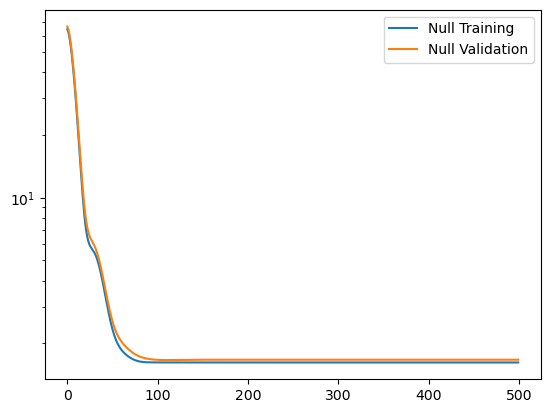

In [79]:
null_training_tensor, null_validation_tensor = crossvalidation(
    nullmodel,
    lambda: nullmodel(nycgraph['footprint'].x),
    nyc_cvs,
    nyc_rebuild_info,
    epochs=epochs
)

null_mean_tl = null_training_tensor.mean(axis=0)
null_mean_vl = null_validation_tensor.mean(axis=0)

plt.plot(null_mean_tl, label="Null Training")
plt.plot(null_mean_vl, label="Null Validation")
plt.legend()

plt.yscale("log")
plt.show()

CV Loop:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

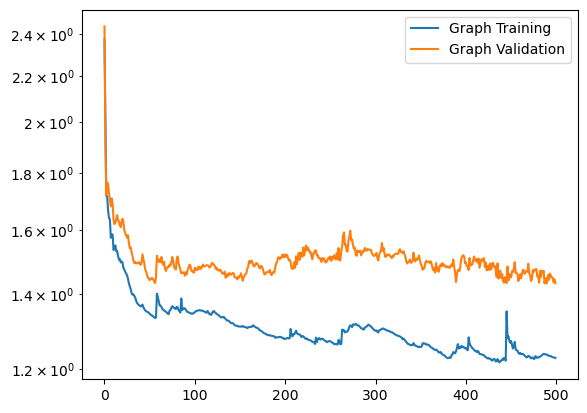

In [80]:
graph_training_tensor, graph_validation_tensor = crossvalidation(
    model,
    lambda: model(nycgraph.x_dict, nycgraph.edge_index_dict),
    nyc_cvs,
    nyc_rebuild_info,
    epochs=epochs
)

mean_tl = graph_training_tensor.mean(axis=0)
std_tl = graph_training_tensor.std(axis=0)

mean_vl = graph_validation_tensor.mean(axis=0)
std_vl = graph_validation_tensor.std(axis=0)

plt.plot(mean_tl, label="Graph Training")
plt.plot(mean_vl, label="Graph Validation")
plt.legend()

plt.yscale("log")
plt.show()

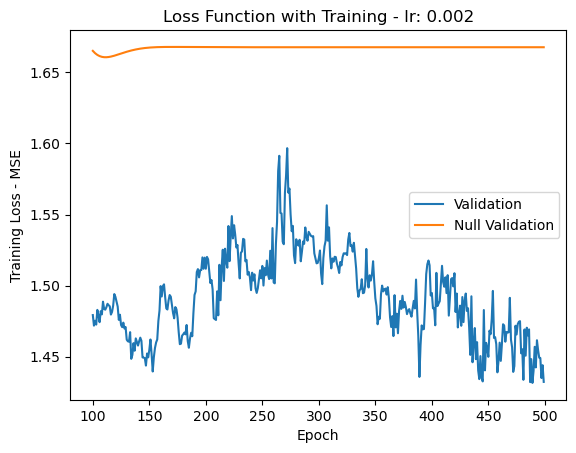

In [81]:
domain = np.arange(0, len(mean_tl))
plt.plot(domain[100:], mean_vl[100:], label="Validation")
# plt.fill_between(domain, mean_vl + std_vl, mean_vl - std_vl, alpha=0.1)

plt.plot(domain[100:], null_mean_vl[100:], label="Null Validation")
# plt.plot(domain, null_mean_tl, label="Null Training")

plt.title(f"Loss Function with Training - lr: {lr}")

plt.xlabel("Epoch")
plt.ylabel("Training Loss - MSE")
plt.legend()
plt.show()

In [85]:
(min(mean_vl) - min(null_mean_vl)) / min(null_mean_vl)

-0.13793081

In [ ]:
(mean_vl.min() - null_mean_vl.min() ) / null_mean_vl.min()

In [ ]:
null_mean_vl.min()

In [ ]:
# param_size = 0
# for param in model.parameters():
#     param_size += param.nelement() * param.element_size()
# buffer_size = 0
# for buffer in model.buffers():
#     buffer_size += buffer.nelement() * buffer.element_size()

# size_all_mb = (param_size + buffer_size) / 1024**2
# print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
nycgraph.x_dict['footprint'].shape

In [ ]:
output[rebuild_info['rebuild_idx']].flatten().shape

In [ ]:
rebuild_info['recorded'].shape

In [ ]:
output[]